### Import Libaries

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import os
import csv
import re
import numpy as np
import pandas as pd

from scipy import spatial
import spacy
import collections
import time
import dask.dataframe as dd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from wordcloud import WordCloud
from wordcloud import STOPWORDS
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt


# 1. Hashing
For this task, we are dealing with hashing algorithms. In particular you will implement hash functions and an algorithm called HyperLogLog (HLL). 

### Import Dataset
 The data is large so we use **dask** for analyzing dataset.

In [ ]:
path = '/content/drive/MyDrive/data/hash.txt'
df = dd.read_csv(path, header=None, names=['Text'])


In [ ]:
df.head()

,Text
0,844082e02a27ddee8d99ea1af94a2969
1,ff96d6665b5c59d3a70bb8f2ba4f10be
2,b64a85884e2b159829331c19e05dbac9
3,1c8836719e84867c26ba2cfeb372c53d
4,b66f73ffd9008d9c99159e164261df51


### Hash Function 1
The first hash function is to convert text to binary string
- From the Text in dataset, the character ranges from 1 to 9 and a to f. the total number of character is 16.
  we use 4 bits to hash 16 characters as the hash table below
- we are going to hash every character to the binary string equivalent

In [ ]:
hashtable = pd.read_excel('hashtable.xlsx', converters={'Original':str,'Binary':str})
hashtable =dict([([a,b]) for a,b in zip(hashtable.Original, hashtable.Binary)])
hashtable

{'0': '0000',
 '1': '0001',
 '2': '0010',
 '3': '0011',
 '4': '0100',
 '5': '0101',
 '6': '0110',
 '7': '0111',
 '8': '1000',
 '9': '1001',
 'a': '1010',
 'b': '1011',
 'c': '1100',
 'd': '1101',
 'e': '1110',
 'f': '1111'}

In [ ]:
# hash a string input and returning into a bit sequence
def hash_function1(string):
    binary_string = list(map(lambda x: hashtable[x], string))
    return ''.join(binary_string)

In [ ]:
# Test hash function
hash_function1('844082e02a27ddee8d99ea1af94a2969')

'10000100010000001000001011100000001010100010011111011101111011101000110110011001111010100001101011111001010010100010100101101001'

In [ ]:
# apply hash_function on dataset
def hash_text1(df):
    """
    Take in a Dataframe, and hash text based on the previously hash function
    """
    df['Text']  = df.Text.apply(lambda x: hash_function1(x))
    
    return df

In [ ]:
# Execute hashfuncion on our dataset
%%time
hash_data1 = df.map_partitions(hash_text1, meta=df)

CPU times: user 3.61 ms, sys: 0 ns, total: 3.61 ms
Wall time: 3.77 ms


In [ ]:
# Results after applying the first hashfunction
data = hash_data1.get_partition(7).compute()
data.head()

,Text
0,1100110100110001011100101010001110101110101011...
1,0111100111100110000001001011100100100011001011...
2,1001111110010111001011011001101100110010100100...
3,1011000110101110001111010100110000110110101001...
4,0100010101110110010000010010111011000000111010...


### Hash Function 2 and implement HypterLogLog Structure
From the output of hash function 1, we take the first N number of bits and use it for bucketing. And we also define a function which return the longest sequence of leading zeroes together in the remaining part of input and save as the value of each bucket coresponding to their indexs


In [ ]:
# Counting number of zero
def count_numberof_zero(string):
    """
    Take in a string , and count the longest sequence of leading zeroes together
    """
    count = 1
    for i in range(len(string)):
        if string[i] == '0':
            count +=1
        else: break
    return count

In [ ]:
# hash function 2
def hash_function2(string, no_of_bit, buckets):
    position = string[:no_of_bit]
    num_of_zero = count_numberof_zero(string[no_of_bit:-1])
    if position not in buckets:
        buckets[position] = num_of_zero
    else:
        max =  buckets[position]
        if num_of_zero > max:
            buckets[position] = num_of_zero
    return buckets

In [ ]:
def hash_text2(df, no_of_bit):
    """
    Take in a Dataframe, and clean based on the previously defined functions (each column is cleaned individually)
    """
    buckets = {}
    df2 = df.Text.apply(lambda x: hash_function2(x, no_of_bit, buckets))
    return buckets

Before implementing the hash function 2. We choose the first b number of bits and m number of substream.
Accorrding to HyperLogLog agorithms,
we assum that:

\begin{align}
  m = 2^{b} \text{ with b }  \in [4.. 16] 
\end{align}

In [ ]:
# we assign b = 6 and m = 64
no_of_bit = 6
no_of_substream = 64

we use dask to divide our dataset to into m number of substreams

In [ ]:
substreams = hash_data1.repartition(npartitions= no_of_substream)

In [ ]:
# Applying the hash function 2 to our output of hash function 1
hash_data2 = substreams.map_partitions(hash_text2, no_of_bit = no_of_bit, meta=dict).compute()
hash_data2

0     {'100001': 14, '111111': 15, '101101': 14, '00...
1     {'110101': 18, '110001': 14, '011001': 15, '01...
2     {'010100': 15, '001011': 16, '011100': 15, '00...
3     {'010101': 16, '010000': 15, '001101': 16, '01...
4     {'000011': 16, '101001': 19, '010110': 14, '01...
                            ...                        
59    {'000011': 17, '010010': 18, '011111': 15, '10...
60    {'111011': 18, '011111': 19, '010011': 15, '00...
61    {'000000': 23, '101011': 18, '010001': 16, '00...
62    {'001010': 15, '010100': 17, '101011': 15, '00...
63    {'010100': 17, '101101': 16, '010010': 16, '01...
Length: 64, dtype: object

In [ ]:
# define a function to filter the max value of each index on all data
def get_max(hash_data2):
    max_values = dict.fromkeys(hash_data2[0].keys(), 0)
    for hash in hash_data2:
        for key, value in hash.items():
            if value > max_values[key]:
                max_values[key] = value
    return max_values

In [ ]:
max_values = get_max(list(hash_data2))
max_values

{'000000': 23,
 '000001': 23,
 '000010': 19,
 '000011': 22,
 '000100': 25,
 '000101': 21,
 '000110': 20,
 '000111': 23,
 '001000': 23,
 '001001': 24,
 '001010': 21,
 '001011': 22,
 '001100': 26,
 '001101': 20,
 '001110': 25,
 '001111': 21,
 '010000': 24,
 '010001': 25,
 '010010': 24,
 '010011': 21,
 '010100': 22,
 '010101': 23,
 '010110': 24,
 '010111': 20,
 '011000': 26,
 '011001': 21,
 '011010': 25,
 '011011': 22,
 '011100': 21,
 '011101': 21,
 '011110': 21,
 '011111': 23,
 '100000': 25,
 '100001': 25,
 '100010': 21,
 '100011': 23,
 '100100': 22,
 '100101': 24,
 '100110': 20,
 '100111': 23,
 '101000': 22,
 '101001': 21,
 '101010': 21,
 '101011': 21,
 '101100': 24,
 '101101': 19,
 '101110': 22,
 '101111': 21,
 '110000': 21,
 '110001': 23,
 '110010': 27,
 '110011': 21,
 '110100': 28,
 '110101': 20,
 '110110': 22,
 '110111': 22,
 '111000': 23,
 '111001': 22,
 '111010': 19,
 '111011': 19,
 '111100': 24,
 '111101': 22,
 '111110': 21,
 '111111': 20}

In [ ]:
# Calculate the cardinary of Dataset
def cardinality(max_values):
    m = len(max_values)
    constant = 0.709
    
    sum_max = sum([2**(-int(value)) for key, value in max_values.items()])

    cardinality = constant*m*m/sum_max
    return cardinality

In [ ]:
estimated_cardinality = cardinality(max_values)
estimated_cardinality

114186867.4517627

In [ ]:
real_cardinality = df.shape[0].compute()
real_cardinality

139000000

In [ ]:
# The error of Filter
relative_error = 1.04/np.sqrt(no_of_substream)
relative_error

0.13

After applying HyperLogLog, we estimate the cardinality of dataset is about ***114,186,867*** compared with the real cardinality is ***139,000,000*** and the relative error is 13%

# 2. Clustering
We play with a dataset gathering reviews 560k of fine foods from Amazon. The reviews include much information. We focus on the reviews' plain text and try to cluster the products 74k

### Import Data

In [ ]:
path = 'C:\\Users\\lucas\\Reviews.csv'
data = pd.read_csv(path)

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Data Preprocessing
We used nltk libraries to remove stopwords and punctuation
Then we also used spacy for the lemmatization 

In [ ]:
stopwords = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
tokenizer = RegexpTokenizer(r'\w+')
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner',"tagger"])


In [ ]:
def pre_process(text):
    """
    This allow us to identify stop word in english and remove them. We are also removing character with single length (e.g. "s")
    """    
    # Puncuation
    word_tokens = tokenizer.tokenize(text)

    # stopwords
    list_to_remove = ['b','br','span', 'one' , 'id', 'none' ]
    text = [w.lower() for w in word_tokens if w.lower() not in stopwords and w.lower() not in list_to_remove  and not(len(w) == 1 and w.isalpha())]
    
    # Lemmatization
    doc = nlp(' '.join(text))
    text = " ".join([token.lemma_ for token in doc])
    return text

In [ ]:
def clean_text(df):
    """
    Take in a Dataframe, and clean based on the pre_process functions (each column is cleaned individually)
    """
    df['Text'] = df.Text.apply(pre_process)
    return df

In [ ]:
df = pd.read_csv(path, usecols= ['ProductId','UserId', 'Score','Text'])
df

,ProductId,UserId,Score,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...
...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,5,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,A3I8AFVPEE8KI5,2,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,A121AA1GQV751Z,5,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,A3IBEVCTXKNOH,5,These are the BEST treats for training and rew...


We implemented dask clean text in parallel in order to obtain a faster code

In [ ]:
dask_dataframe = dd.from_pandas(df, npartitions=20)
df_clean = dask_dataframe.map_partitions(clean_text, meta=df).compute()

In [ ]:
df_clean

,ProductId,UserId,Score,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,5,buy several vitality can dog food product find...
1,B00813GRG4,A1D87F6ZCVE5NK,1,product arrive label jumbo salt peanut peanut ...
2,B000LQOCH0,ABXLMWJIXXAIN,4,confection around century light pillowy citrus...
3,B000UA0QIQ,A395BORC6FGVXV,2,look secret ingredient robitussin believe find...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,great taffy great price wide assortment yummy ...
...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,5,great sesame chicken good well resturants eat ...
568450,B003S1WTCU,A3I8AFVPEE8KI5,2,disappoint flavor chocolate note especially we...
568451,B004I613EE,A121AA1GQV751Z,5,star small give 10 15 train session try train ...
568452,B004I613EE,A3IBEVCTXKNOH,5,well treat train reward dog good groom low cal...


We decided to use TFIDF vectorizer to vectorize our text. <br/>
We also consider these words appearing in less than 10 documents should be removed.

In [ ]:
vectorizer = TfidfVectorizer( min_df=10,
                        strip_accents='unicode',
                        lowercase =True, analyzer='word', token_pattern=r'\w+',
                        use_idf=True, smooth_idf=True, sublinear_tf=True, 
                        stop_words = 'english')
X = vectorizer.fit(df_clean.Text)

Here we implemented SVD to obtain a smaller dimension of our dataset 
We choose 1000 components because we had to obtain a variance greater than 60%

In [ ]:
%%time
svdT = TruncatedSVD(n_components= 1000) 
svdTFit = svdT.fit_transform(X.transform(df_clean.Text))

Wall time: 9min 34s


In [ ]:
print(svdT.explained_variance_ratio_.sum())

0.6122881548278072


In [ ]:
svdTFit.shape

(568454, 1000)

### Implementation of K_Means algorithm from scratch

In [ ]:
def euclidean_distance(x,y):
    return np.sqrt(np.sum((x - y)**2))

In [ ]:
def Kmean_scratch(data, K=5, max_iters = 100):

    n_samples, n_features = data.shape

    # initialize
    random_idxs = np.random.permutation(n_samples)[:K]
    centroids = data[random_idxs]


    for _ in range(max_iters):

        # Calculate clusters
        clusters = [[] for _ in range(K)]

        for idx, sample in enumerate(data):
            distances = [euclidean_distance(sample, centroid) for centroid in centroids]
            closest_index = np.argmin(distances)
            clusters[closest_index].append(idx)

        # Calculate new centroids from the clusters
        old_centroids = centroids

        centroids = np.zeros((K, n_features))

        for cluster_idx, cluster in enumerate(clusters):
            new_centroid = np.mean(data[cluster], axis=0)
            centroids[cluster_idx] = new_centroid
    
        # check if clusters have changed
        if (old_centroids == centroids).all():
            break

    # Classify samples as the index of their clusters
    labels = np.zeros(n_samples)
    for cluster_idx, cluster in enumerate(clusters):
        for sample_index in cluster:
            labels[sample_index] = cluster_idx
    return labels


We have now to chose the number of cluster for the K_means, to do this we need to implement a method which returns the optimal value of k
We choose the elbow method to choose the best K, number of clusters

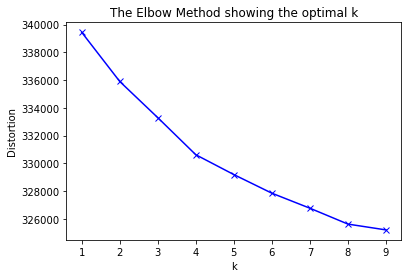

Wall time: 33min 10s


In [ ]:
%%time
# Elbow methods
distortions = []
K = [i for i in range(1,10)]
for k in K: 
    #Building and fitting the model 
    kmeanModel =  KMeans(n_clusters=k).fit(svdTFit)
    distortions.append(kmeanModel.inertia_) 

# Plot elbow methods
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From this plot we can say the the optimal number of clusters is K=4

In [ ]:
%%time
np.random.seed(80)
clusters = Kmean_scratch(svdTFit,4,100)

Wall time: 21min 4s


To visualize, we’ll plot the features in a 2D space.  we need to reduce the dimension before we can plot.  For this, we’ll ues PCA to transform our high dimensional features into 2 dimensions.

In [ ]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(svdTFit)

Text(0.5, 1.0, 'Our K_Means with K=4 clusters')

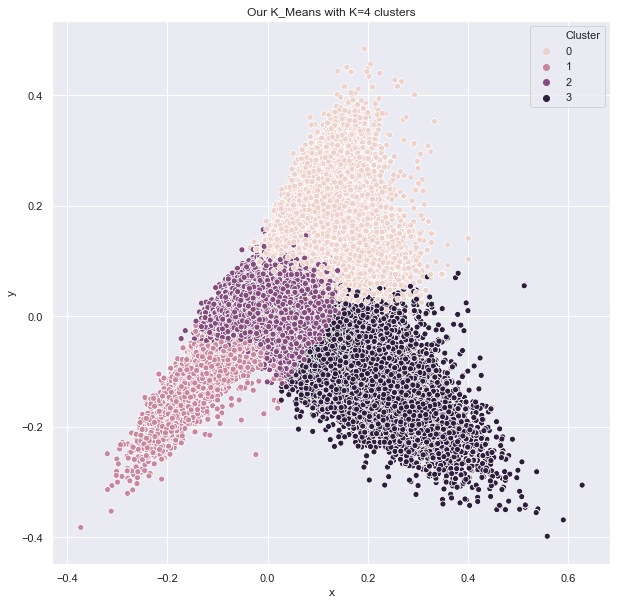

In [ ]:
pca_comp= pd.DataFrame(data=scatter_plot_points, columns=('x','y'))
pca_comp['Cluster']= clusters
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(data=pca_comp,x='x',y='y',markers='x',hue='Cluster')
plt.title('Our K_Means with K=4 clusters')

Implementing the K_Means ++ 

In [ ]:
%%time
kmeans = KMeans(n_clusters=4, init='k-means++').fit(svdTFit)

Wall time: 3min 39s


Text(0.5, 1.0, 'K_Means++ with K=4 clusters')

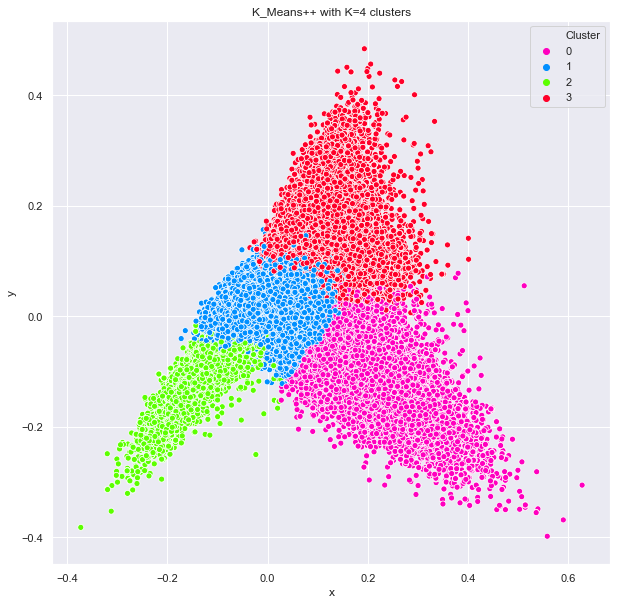

In [ ]:
pca_comp= pd.DataFrame(data=scatter_plot_points, columns=('x','y'))
pca_comp['Cluster']= kmeans.labels_
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(data=pca_comp,x='x',y='y',markers='x',hue='Cluster',palette = "gist_rainbow_r")
plt.title('K_Means++ with K=4 clusters')

Like we thought the yet implemented K_Means++ is faster than our from scratch but the results looks like the same

### Analyse the obtained clusters
A Wordcloud (or Tag cloud) is a visual representation of text data. It displays a list of words, the importance of each being shown with font size or colorm. This format is useful for quickly perceiving the most prominent term

In [ ]:
df_clean['Clusters'] = clusters

In [ ]:
df_clean.head()

,ProductId,UserId,Score,Text,Clusters
0,B001E4KFG0,A3SGXH7AUHU8GW,5,buy several vitality dog food product find goo...,1
1,B00813GRG4,A1D87F6ZCVE5NK,1,product arrive label jumbo salt peanut peanut ...,2
2,B000LQOCH0,ABXLMWJIXXAIN,4,confection around century light pillowy citrus...,2
3,B000UA0QIQ,A395BORC6FGVXV,2,look secret ingredient robitussin believe find...,2
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,great taffy great price wide assortment yummy ...,2


In [ ]:
def create_wordcloud(text, cluster):
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                    max_words=200,
                    stopwords=stopwords)
    words = wc.generate(text)
    # Plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(211)
    ax.imshow(words,interpolation='bilinear')
    ax.axis("off")
    ax.set_title('Reviews of Cluster '+ str(cluster),fontsize=20)

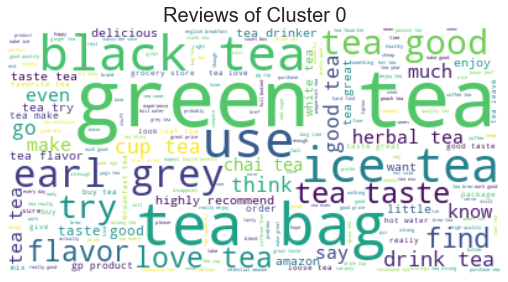

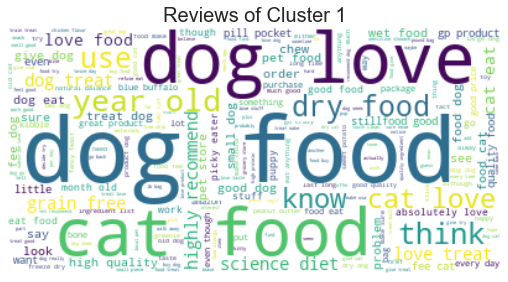

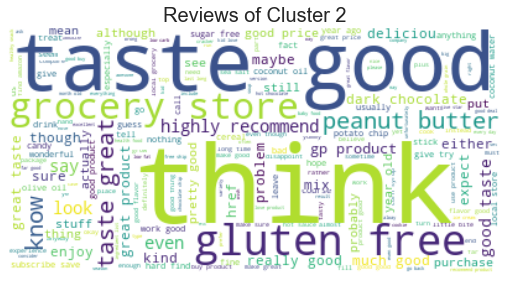

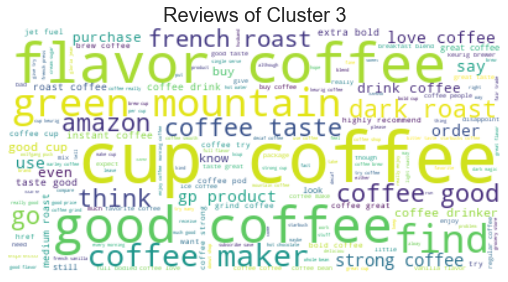

In [ ]:
for cluster in np.sort(df_clean.Clusters.unique()):
    word_df =  df_clean[df_clean.Clusters == cluster]
    create_wordcloud(" ".join(word_df.Text.values),cluster )


### Number of unique products in each cluster


In [ ]:
unique_products = df_clean.groupby('Clusters').ProductId.nunique().to_frame('no_of_products').reset_index()

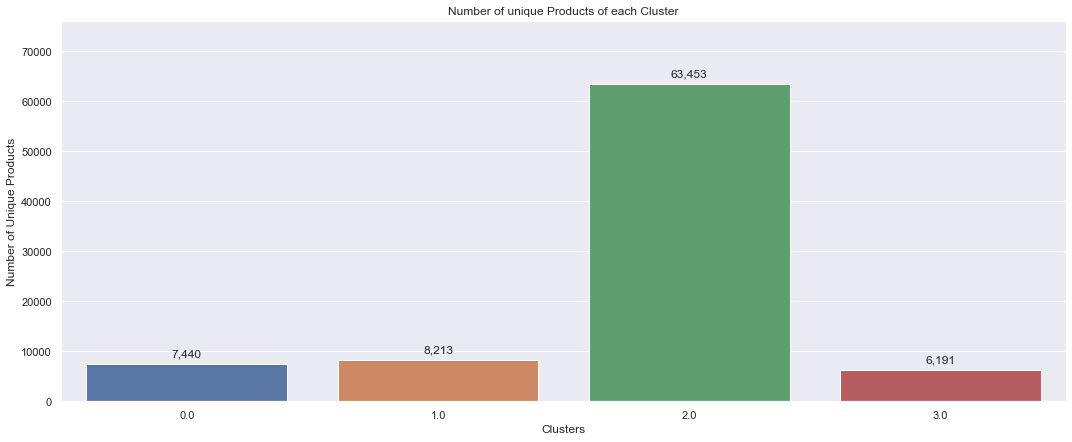

In [ ]:
plt.figure(figsize=(18,7))
plot = sns.barplot(x='Clusters',y='no_of_products',data=unique_products)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Number of unique Products of each Cluster')
plt.xlabel('Clusters')
plt.ylabel('Number of Unique Products')
plt.ylim(0,unique_products['no_of_products'].max()*1.2);

As we can see in the barplot the cluster 2 has the biggest number of 'ProductId'

### Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant!


In this part for first we plot a table of the distribution of each cluster

In [ ]:
df_clean.groupby('Clusters').Score.describe()

,count,mean,std,min,25%,50%,75%,max
Clusters,,,,,,,,
0,45903.0,4.336666,1.176868,1.0,4.0,5.0,5.0,5.0
1,68651.0,4.229276,1.309560,1.0,4.0,5.0,5.0,5.0
2,391759.0,4.158843,1.332769,1.0,4.0,5.0,5.0,5.0
3,62141.0,4.172479,1.252801,1.0,4.0,5.0,5.0,5.0


We evaluated the score's distribution in each cluster with the mean of each cluster  

In [ ]:
mean_score = df_clean.groupby('Clusters').Score.mean().to_frame('mean').reset_index() #dataframe of the means

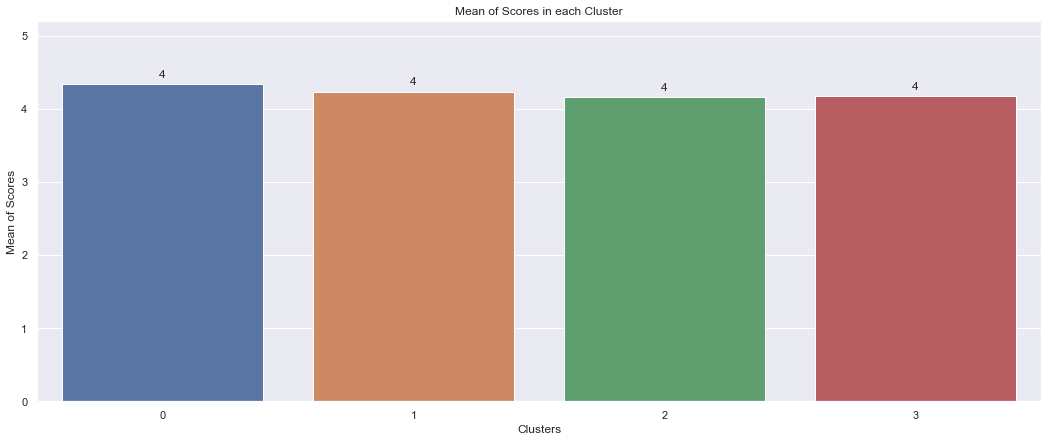

In [ ]:
plt.figure(figsize=(18,7))
plot = sns.barplot(x='Clusters',y='mean',data=mean_score)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Mean of Scores in each Cluster')
plt.xlabel('Clusters')
plt.ylabel('Mean of Scores')
plt.ylim(0,mean_score['mean'].max()*1.2);

We can see that the means are preatty much the same, there is no a significant difference between them

We evaluated the score's distribution in each cluster with the number of score each cluster

In [ ]:
no_score_each_cluster = df_clean.groupby(['Clusters', 'Score']).Score.count().to_frame('No_of_each_score').reset_index()

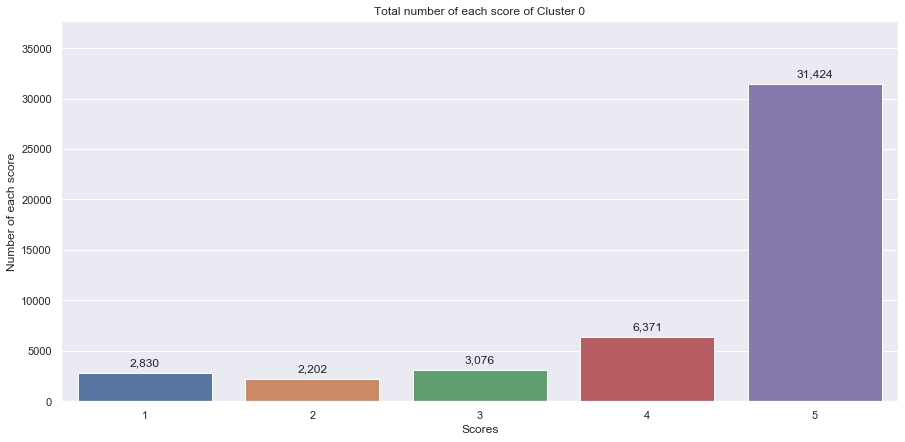

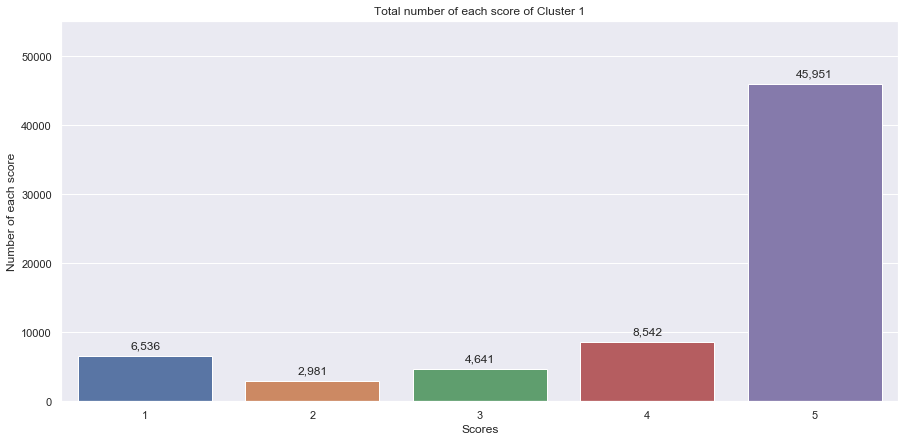

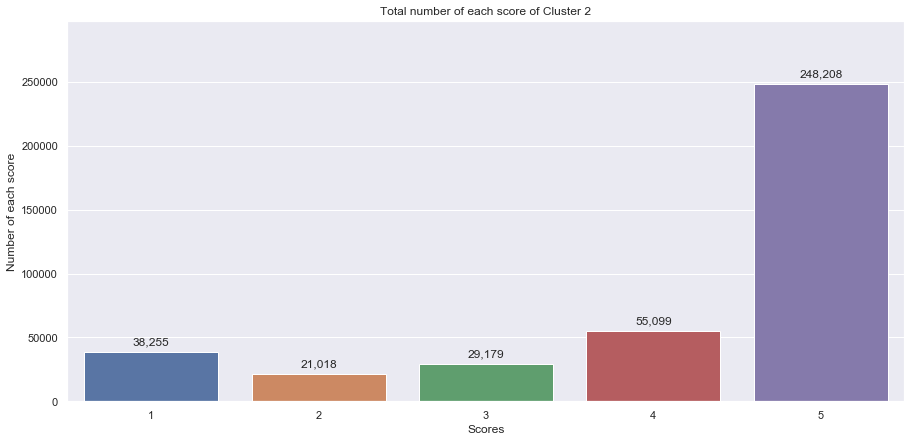

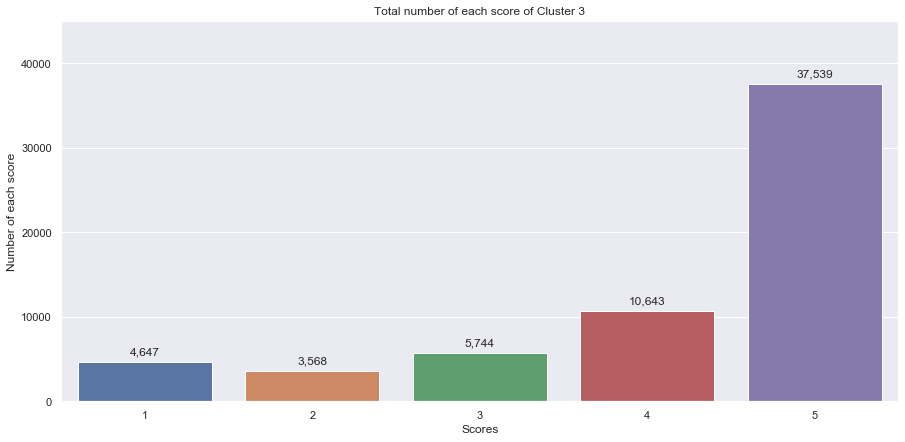

In [ ]:
for cluster in no_score_each_cluster['Clusters'].unique():
    score_count = no_score_each_cluster[no_score_each_cluster['Clusters'] == cluster].reset_index()
    plt.figure(figsize=(15,7))
    plot = sns.barplot(x='Score',y='No_of_each_score',data=score_count)
    for p in plot.patches:
        plot.annotate(format(p.get_height(), ',.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center',
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')

    plt.title('Total number of each score of Cluster ' +str(cluster))
    plt.xlabel('Scores')
    plt.ylabel('Number of each score')
    plt.ylim(0,score_count['No_of_each_score'].max()*1.2);

### Get the number of unique users writing reviews in each cluster

In [ ]:
user_per_cluster = df_clean.groupby('Clusters').UserId.nunique().to_frame('No_of_unique_user').reset_index()

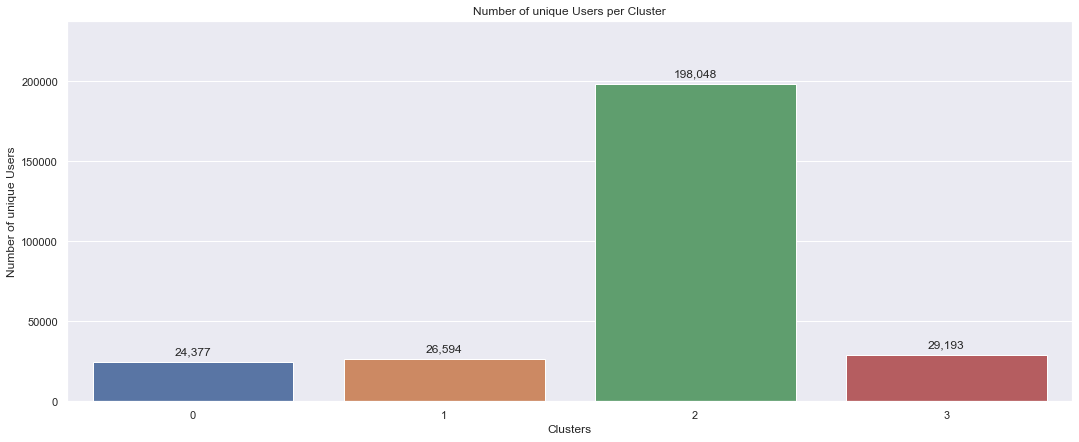

In [ ]:
plt.figure(figsize=(18,7))
plot = sns.barplot(x='Clusters',y='No_of_unique_user',data=user_per_cluster)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Number of unique Users per Cluster')
plt.xlabel('Clusters')
plt.ylabel('Number of unique Users')
plt.ylim(0,user_per_cluster['No_of_unique_user'].max()*1.2);

The barplot shows clearly that the cluster 2 has the most number of reviewrs

# 3. Algorithm Question

You are given an array with A with n integer numbers.

Let s = min{ A[1], ..., A[n] } and b = max { A[1], ..., A[n] }.
Let r = b - s

Prove that we can sort A in time O(n + r).

In [ ]:
def counting_sort(arr, min_value, max_value):
  
  r = max_value - min_value

  # Count the number of times each value appear in array
  counts = [ 0 for i in range(r+1)]

  for item in arr:
    counts[item - min_value] += 1
 
  # Building a next index array
  no_of_items_before = 0
  for i, count in enumerate(counts):
    counts[i] = no_of_items_before
    no_of_items_before += count

  # initialize the sorted array
  sorted_arr = [None for i in range(len(arr))]

  for item in arr:
    sorted_arr[counts[item-min_value]] = item
    counts[item-min_value] += 1

  return sorted_arr

In [ ]:
arr1 = [5, 28, 6, 6, 8, 9, 10]

In [ ]:
counting_sort(arr1,5, 28)

[5, 6, 6, 8, 9, 10, 28]

In [ ]:
arr2 = [0, 1, 0, 1, 1, 0, 1, 0, 1, 0]

In [ ]:
counting_sort(arr2, 0, 1)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


Counting sort takes O(n + r) time where n is the number of items in an array we're sorting and r is different between max value and min value
Proof:

\begin{align}
 T_{countingsort}= c_1 + c_2(r+1) + c_3n + c_4 +  c_5(r+1) + c_6n + c_7n + c_8
                 = an + br + c = O(n+r)
\end{align}

where: <br/>
    n is the length of array <br/>
    r is the different between max value and min value in array <br/>
    a,b,c, c1...c8 are constants



# Thank you for reading. Happy day!!!